In [56]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [57]:
# Importing the dataset
data = pd.read_csv("order_data.csv")
data.head()

,Date,TimeOfDay,MenuItem,Quantity
0,2023-01-01,07:00,Chicken Tikka Masala,2
1,2023-01-01,07:00,Shrimp Scampi,2
2,2023-01-01,07:00,Chicken Alfredo,3
3,2023-01-01,07:00,Caesar Salad,1
4,2023-01-01,07:00,Tiramisu,3


In [58]:
# Convert 'Date' column to numeric representation
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['NumericDate'] = (data['Date'] - start_date).dt.days + 1

In [59]:
def extract_hour(timestamp):
    time_obj = datetime.strptime(timestamp, '%H:%M')
    return time_obj.hour

# Applying the function to the 'TimeofDay' column to extract hours
data['TimeOfDay'] = data['TimeOfDay'].apply(extract_hour)

In [60]:
# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

In [61]:
data = data.groupby(['DateTime', 'Date', 'NumericDate', 'TimeOfDay', 'MenuItem']).agg({'Quantity': 'sum'}).reset_index()
data.head(5)

             DateTime       Date  NumericDate  TimeOfDay         MenuItem  \
0 2023-01-01 07:00:00 2023-01-01            1          7  Beef Stroganoff   
1 2023-01-01 07:00:00 2023-01-01            1          7       Beef Tacos   
2 2023-01-01 07:00:00 2023-01-01            1          7  Breakfast Combo   
3 2023-01-01 07:00:00 2023-01-01            1          7     Caesar Salad   
4 2023-01-01 07:00:00 2023-01-01            1          7  Chicken Alfredo   

   Quantity  
0         5  
1         4  
2         1  
3         1  
4         3  


In [62]:
label_encoders = {}
categorical_columns = ['MenuItem']

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col]) + 1

print(data.head())

             DateTime       Date  NumericDate  TimeOfDay  MenuItem  Quantity
0 2023-01-01 07:00:00 2023-01-01            1          7         1         5
1 2023-01-01 07:00:00 2023-01-01            1          7         2         4
2 2023-01-01 07:00:00 2023-01-01            1          7         3         1
3 2023-01-01 07:00:00 2023-01-01            1          7         4         1
4 2023-01-01 07:00:00 2023-01-01            1          7         5         3


In [63]:
X_xgb = data.iloc[:, 2:-1].values
y_xgb = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.4, random_state=42)

# Create XGBoost regressor and specify hyperparameters
model_xgb = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate
    random_state=0
)

# Train the model
model_xgb.fit(X_train_xgb, y_train_xgb)

# Make predictions on the test set
predictions_xgb = model_xgb.predict(X_test_xgb)

score_xgb = model_xgb.score(X_test_xgb, y_test_xgb)
mse_xgb = mean_squared_error(y_test_xgb, predictions_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, predictions_xgb)
r2_xgb = r2_score(y_test_xgb, predictions_xgb)

print("Score:", score_xgb)
print("Mean Squared Error (MSE):", mse_xgb)
print("Root Mean Squared Error (RMSE):", rmse_xgb)
print("Mean Absolute Error (MAE):", mae_xgb)
print("R-squared (R2):", r2_xgb)

Score: 0.8495986599244272
Mean Squared Error (MSE): 8.493663321732035
Root Mean Squared Error (RMSE): 2.914389013452397
Mean Absolute Error (MAE): 2.2134085197024005
R-squared (R2): 0.8495986599244272


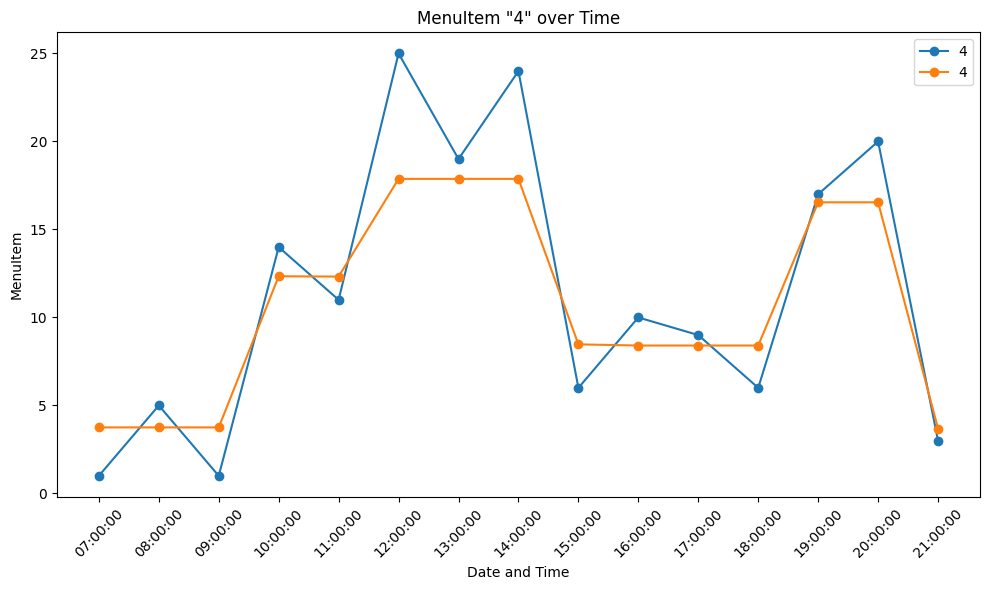

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# Selecting features
X = data[['DateTime', 'NumericDate', 'TimeOfDay', 'MenuItem', 'Quantity']]

# Filter for a specific date and menu item
selected_date = '2023-09-05'  # Replace with your desired date in 'YYYY-MM-DD' format
selected_menu_item = 4 # Replace with the menu item you want to plot


s_d = X[(X['DateTime'].dt.date == pd.to_datetime(selected_date).date()) & (X['MenuItem'] == selected_menu_item)]
# Selecting features for the specific menu item
X_d = s_d[['NumericDate', 'TimeOfDay', 'MenuItem']]
y_d = s_d['Quantity']

# Predicting for the specific menu item using the already trained model
predictions_d = model_xgb.predict(X_d)

selected_data = X[(X['DateTime'].dt.date == pd.to_datetime(selected_date).date()) & (X['MenuItem'] == selected_menu_item)]
plt.figure(figsize=(10, 6))
plt.plot(selected_data['DateTime'].dt.strftime('%H:%M:%S'), selected_data['Quantity'], marker='o', linestyle='-', label=selected_menu_item)
plt.plot(selected_data['DateTime'].dt.strftime('%H:%M:%S'), predictions_d, marker='o', linestyle='-', label=selected_menu_item)
plt.xlabel('Date and Time')
plt.ylabel('MenuItem')
plt.title(f'MenuItem "{selected_menu_item}" over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
